In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# 1. Cargar datos
df = pd.read_csv('dataset_con_clusters.csv')

# 2. Definir features, target y cluster
feature_cols = [
    'Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 
    'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)',
    'Workout_Frequency (days/week)', 'Experience_Level', 'BMI',
    'Workout_Cardio', 'Workout_HIIT', 'Workout_Strength', 'Workout_Yoga'
]
target_col = 'Calories_Burned'
cluster_col = 'cluster'

X = df[feature_cols].values
y = df[target_col].values
clusters = df[cluster_col].values

# 3. Preparar arrays para almacenar las predicciones de todos los folds
global_preds = np.zeros(len(df))
local_preds  = np.zeros(len(df))

# 4. Stratified K-Fold sobre los clusters (5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X, clusters):
    # Separar train/validation
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    clusters_train, clusters_val = clusters[train_idx], clusters[val_idx]
    
    # 4.1 Entrenar modelo global en este fold
    global_model = GradientBoostingRegressor(random_state=42)
    global_model.fit(X_train, y_train)
    global_preds[val_idx] = global_model.predict(X_val)
    
    # 4.2 Entrenar modelo local para cada cluster dentro del fold
    for cl in np.unique(clusters):
        # Indices de entrenamiento y validación para el cluster cl
        idx_train_cl = train_idx[clusters_train == cl]
        idx_val_cl   = val_idx[clusters_val == cl]
        
        if len(idx_train_cl) > 0 and len(idx_val_cl) > 0:
            X_train_cl = X[idx_train_cl]
            y_train_cl = y[idx_train_cl]
            X_val_cl   = X[idx_val_cl]
            
            local_model = GradientBoostingRegressor(random_state=42)
            local_model.fit(X_train_cl, y_train_cl)
            local_preds[idx_val_cl] = local_model.predict(X_val_cl)

# 5. Calcular errores absolutos
abs_error_global = np.abs(y - global_preds)
abs_error_local  = np.abs(y - local_preds)

# 6. Construir DataFrame con cluster y errores
results_df = pd.DataFrame({
    'cluster': clusters,
    'abs_error_global': abs_error_global,
    'abs_error_local': abs_error_local
})

# 7. Resumir cuántas veces local < global por cluster
summary = results_df.groupby('cluster').apply(
    lambda grp: pd.Series({
        'Total Samples': len(grp),
        'Escenario A Count': (grp['abs_error_local'] < grp['abs_error_global']).sum(),
        'Escenario A %': round((grp['abs_error_local'] < grp['abs_error_global']).mean() * 100, 2)
    })
).reset_index()

# 8. Mostrar el resumen
print(summary)


   cluster  Total Samples  Escenario A Count  Escenario A %
0        0          191.0               71.0          37.17
1        1          280.0               89.0          31.79
2        2          312.0              115.0          36.86
3        3          190.0               62.0          32.63


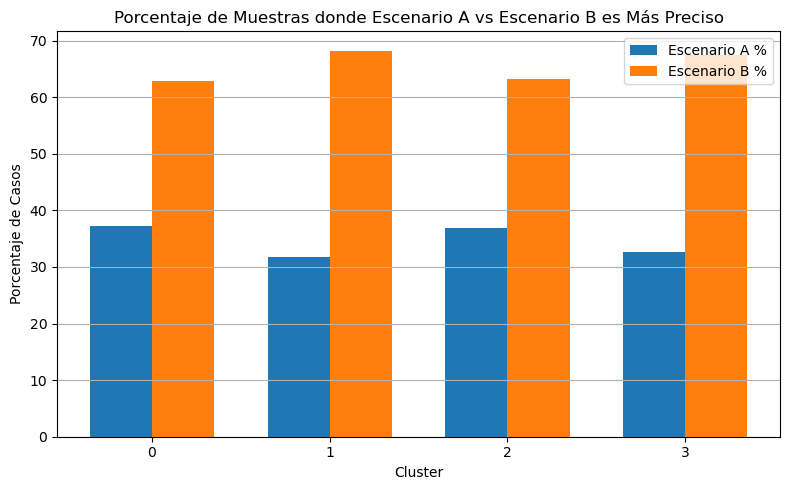

In [6]:
# 9. Gráfico de barras
clusters_list = summary['cluster'].astype(str)
local_better = summary['Escenario A %']
global_better = 100 - local_better

x = np.arange(len(clusters_list))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, local_better, width, label='Escenario A %')
ax.bar(x + width/2, global_better, width, label='Escenario B %')

ax.set_xlabel('Cluster')
ax.set_ylabel('Porcentaje de Casos')
ax.set_title('Porcentaje de Muestras donde Escenario A vs Escenario B es Más Preciso')
ax.set_xticks(x)
ax.set_xticklabels(clusters_list)
ax.legend()
ax.grid(True, axis='y')

plt.tight_layout()
plt.show()